# Beercan or Bacon

Learning to use the fast.ai toolchain, I proposed this excersise to myself to practice both sourcing data from api calls to image search providers and to practice using the fast.ai tools. 

This is an attempt to make a classifier which can detect if an image is of a beercan, bacon or neither. The classifier is a simple homage to the awkward time of the internet between web1.0 and web2.0, where a single serving humour website brought to the attention that beercan and bacon sound identical in Jamaican accents.

### imports

In [1]:
from fastbook import *
from fastai.vision.widgets import *

from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth

### Setup of API and image collection

In [2]:
key = 'c83d7ca0676d40afb7c86480ec0b59f7'

In [3]:
def search_images_bing(key, term, min_sz=128):
    client = api('https://panda-test-image-search.cognitiveservices.azure.com/', auth(key))
    return L(client.images.search(query=term, count=150, min_height=min_sz, min_width=min_sz).value)

### Define search queries and grab images
note: searching for 'beercan' brings up multiple images of a particular lens, but by adding the space it stops those results, alternative would have been to add NOT queries such as `'beercan -(lens)'`

In [4]:
classes = ['beercan', 'bacon']
search_terms = ['beer can -recipe -chicken', 'bacon -kevin -francis -jam']

In [5]:
path = Path('beer_or_bacon')
if not path.exists():
    path.mkdir()

In [6]:
for i, search in enumerate(classes):
    dest = (path/search)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, search_terms[i])
    download_images(dest, urls=results.attrgot('content_url'))

### Check if images downloaded correctly and are showing correctly

In [7]:
fns = get_image_files(path)
fns

(#371) [Path('beer_or_bacon/bacon/00000011.jpg'),Path('beer_or_bacon/bacon/00000017.jpg'),Path('beer_or_bacon/bacon/00000021.jpg'),Path('beer_or_bacon/bacon/00000018.jpg'),Path('beer_or_bacon/bacon/00000020.jpg'),Path('beer_or_bacon/bacon/00000015.jpg'),Path('beer_or_bacon/bacon/00000019.jpg'),Path('beer_or_bacon/bacon/00000023.jpg'),Path('beer_or_bacon/bacon/00000022.jpg'),Path('beer_or_bacon/bacon/00000027.jpg')...]

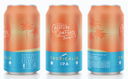

In [8]:
im = Image.open(fns[220])
im.to_thumb(128,128)

In [9]:
failed = verify_images(fns)
failed

(#8) [Path('beer_or_bacon/bacon/00000087.jpg'),Path('beer_or_bacon/bacon/00000142.jpg'),Path('beer_or_bacon/beercan/00000101.jpg'),Path('beer_or_bacon/beercan/00000113.jpg'),Path('beer_or_bacon/beercan/00000051.jpg'),Path('beer_or_bacon/beercan/00000070.jpg'),Path('beer_or_bacon/beercan/00000141.jpg'),Path('beer_or_bacon/beercan/00000147.jpg')]

In [10]:
failed.map(Path.unlink);

### Use fast.ai methods and blocks to load data up

In [11]:
imageloader = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
# parent_label is a function to take the folder name, aka beercan or bacon, as the labels


In [12]:
# resize and transform with data augmentations
imageloader= imageloader.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = imageloader.dataloaders(path)

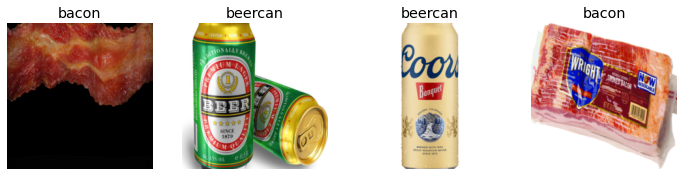

In [13]:
dls.valid.show_batch(max_n=4, nrows=1)

### Create Convolutional neural network learner object and train

In [14]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.755251,0.066375,0.027778,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.171768,0.077166,0.013889,00:10
1,0.142507,0.085743,0.013889,00:09
2,0.113536,0.083662,0.013889,00:09
3,0.094494,0.082524,0.013889,00:09


### Check classification interpretations and top losses for images

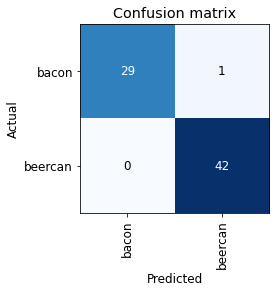

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

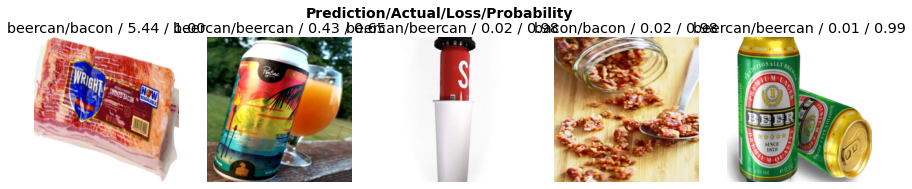

In [16]:
interp.plot_top_losses(5, nrows=1)

As expected some of these images have low prediction confidence because they are images of chickens and deserts!

### Attempt to clean some of these images out

In [17]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [18]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Rerun having fixed the images

In [20]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.764020,0.074297,0.013889,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.245442,0.076526,0.013889,00:09
1,0.182087,0.077922,0.013889,00:09
2,0.132423,0.085877,0.013889,00:10
3,0.113492,0.091467,0.013889,00:09


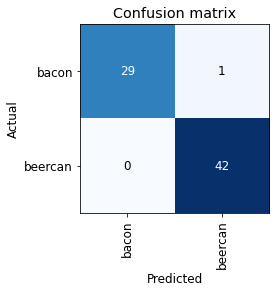

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

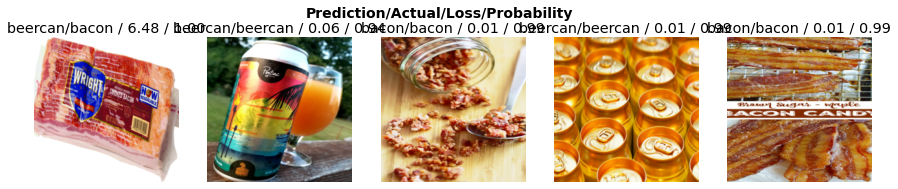

In [22]:
interp.plot_top_losses(5, nrows=1)

In [23]:
learn.export()

In [24]:
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('export_bears.pkl'),Path('export.pkl')]